Dos divisiones de lo parametros:

* Propiedades de la masa y la densidad:
      - Masa del disco
      - gamma -> Exponente del perfil de densidad superficial. Que tan rapido decae el brillo desde el centro hacia afuera.
      - psi -> flaring index

* Propiedades geometricas y de orientacion
      - Rc -> tamano del disco
      - incl -> inclinacion del disco
      - H30 -> Define el grosor del disco en un radio de referencia.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

Gráfico de curvas de pérdida guardado como 'loss_curves_plot.png'


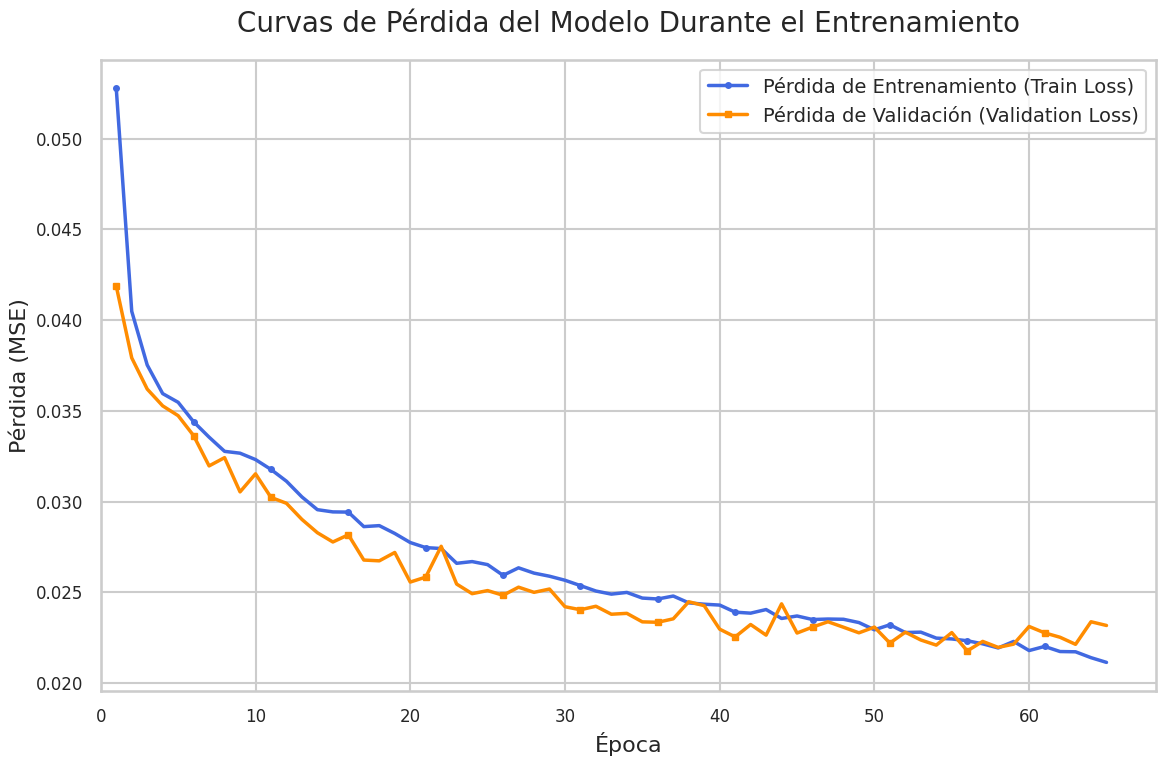

In [3]:
#Analisis del modelo Two-Channel - Este corresponde al modelo que estima mDisk, gamma, psi
os.chdir("/home/aargomedo/TESIS/Modelos/Two-Channel-Big")

# --- 1. Cargar los datos de pérdida ---
try:
    loss_train = np.load('loss_train.npy')
    loss_val = np.load('loss_val.npy')
except FileNotFoundError:
    print("Error: Asegúrate de que 'loss_train.npy' y 'loss_val.npy' estén en el directorio correcto.")
    exit()

# --- 2. Configuración del estilo del gráfico ---
# Usamos el estilo de seaborn que es muy popular en publicaciones científicas
sns.set_theme(style="whitegrid", context="talk") # "talk" hace que las fuentes sean más grandes y legibles

# Crear la figura y los ejes
# figsize=(12, 8) crea un gráfico de buen tamaño y proporción
fig, ax = plt.subplots(figsize=(12, 8))

# --- 3. Generar los datos para el eje X (Épocas) ---
epochs = range(1, len(loss_train) + 1)

# --- 4. Plotear las curvas ---
# Curva de Entrenamiento
ax.plot(epochs, loss_train, 
        label='Pérdida de Entrenamiento (Train Loss)', 
        color='royalblue',          # Un azul profesional
        linewidth=2.5,              # Una línea un poco más gruesa
        marker='o',                 # Añadir marcadores de puntos
        markersize=4,               # Tamaño de los marcadores
        markevery=5)                # Muestra un marcador cada 5 épocas para no saturar

# Curva de Validación
ax.plot(epochs, loss_val, 
        label='Pérdida de Validación (Validation Loss)', 
        color='darkorange',     
        linewidth=2.5,
        marker='s',               
        markersize=4,
        markevery=5)

ax.set_title('Curvas de Pérdida del Modelo Durante el Entrenamiento', fontsize=20, pad=20)
ax.set_xlabel('Época', fontsize=16)
ax.set_ylabel('Pérdida (MSE)', fontsize=16)

ax.legend(loc='upper right', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.set_xlim(left=0)

plt.tight_layout()
plt.savefig('loss_curves_plot.png', dpi=300)

print("Gráfico de curvas de pérdida guardado como 'loss_curves_plot.png'")
plt.show()

--- Diagnóstico y Limpieza de Datos ---
Se encontraron 16902 de 16902 muestras válidas (100.00%).
Se descartaron 0 muestras con valores no finitos.

Usando todos los puntos válidos para los scatter plots...


IndexError: index 3 is out of bounds for axis 0 with size 3

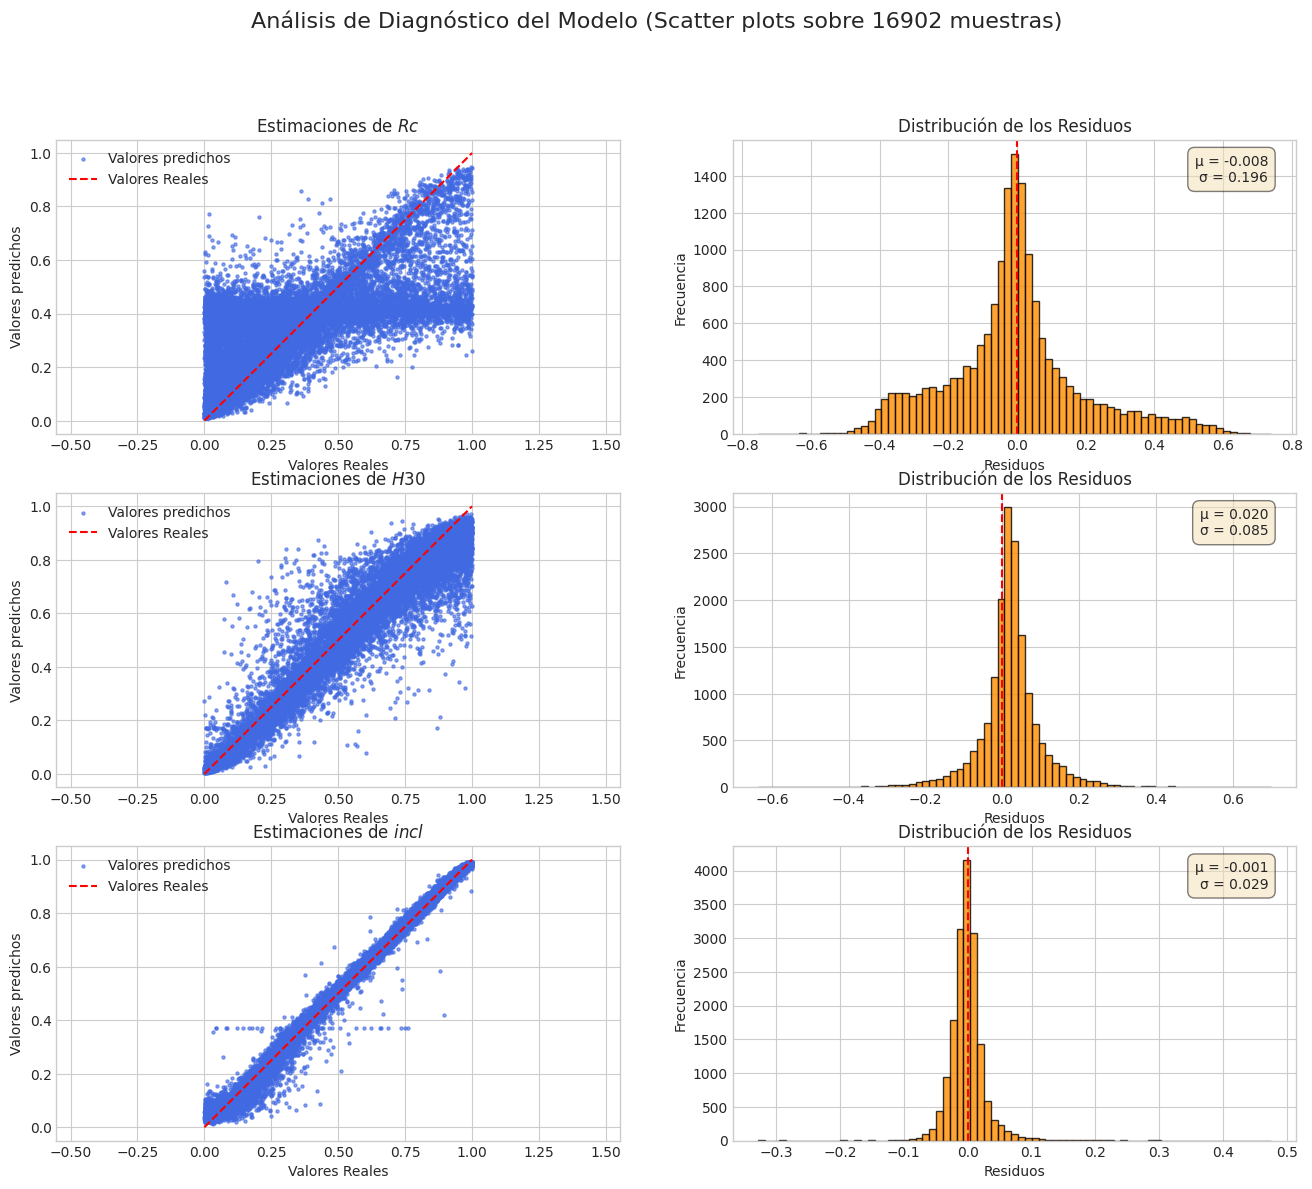

In [3]:


# =============================================================================
# --- 1. Cargar y limpiar los datos ---
# =============================================================================
try:
    test_outputs = np.load('/home/aargomedo/TESIS/Modelos/Two-Channel/swin_tiny/default/test_outputs.npy')
    test_targets = np.load('/home/aargomedo/TESIS/Modelos/Two-Channel/swin_tiny/default/test_targets.npy')
except FileNotFoundError:
    print("Error: Asegúrate de que 'test_outputs.npy' y 'test_targets.npy' estén en el directorio correcto.")
    exit()

print("--- Diagnóstico y Limpieza de Datos ---")
valid_rows_mask = np.isfinite(test_outputs).all(axis=1) & np.isfinite(test_targets).all(axis=1)
filtered_outputs = test_outputs[valid_rows_mask]
filtered_targets = test_targets[valid_rows_mask]
residuals = filtered_targets - filtered_outputs

num_total = len(test_outputs)
num_valid = len(filtered_outputs)
print(f"Se encontraron {num_valid} de {num_total} muestras válidas ({num_valid/num_total:.2%}).")
print(f"Se descartaron {num_total - num_valid} muestras con valores no finitos.")

if num_valid == 0:
    print("\nNo quedaron datos válidos después del filtrado. No se puede generar el gráfico.")
    exit()

# =============================================================================
# --- 2. Submuestreo Aleatorio para Graficar ---
# =============================================================================
num_samples_to_plot = 20000  # Ajusta este número: más alto = más detalle, más bajo = más rápido
total_valid_samples = len(filtered_outputs)

if total_valid_samples > num_samples_to_plot:
    print(f"\nSubmuestreando {num_samples_to_plot} de {total_valid_samples} puntos para los scatter plots...")
    random_indices = np.random.choice(total_valid_samples, num_samples_to_plot, replace=False)
    
    # Crear arrays específicos para los scatter plots
    plot_outputs = filtered_outputs[random_indices]
    plot_targets = filtered_targets[random_indices]
    plot_residuals = residuals[random_indices]
else:
    print("\nUsando todos los puntos válidos para los scatter plots...")
    plot_outputs = filtered_outputs
    plot_targets = filtered_targets
    plot_residuals = residuals

# =============================================================================
# --- 3. Generación del Gráfico ---
# =============================================================================
param_names = [r'$Rc$', r'$H30$', r'$incl$', r'$mDisk$', r'$\gamma$', r'$\psi$']
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 13))
fig.suptitle(f'Análisis de Diagnóstico del Modelo (Scatter plots sobre {len(plot_outputs)} muestras)', fontsize=16)

for i, param_name in enumerate(param_names):
    # Datos para los scatter plots (submuestreados)
    y_true_plot = plot_targets[:, i]
    y_pred_plot = plot_outputs[:, i]
    res_plot = plot_residuals[:, i]
    
    # Datos para el histograma (completos)
    res_full = residuals[:, i]

    # --- Gráfico 1: Estimaciones ---
    ax = axes[i, 0]
    ax.scatter(y_true_plot, y_pred_plot, s=5, alpha=0.6, c='royalblue', label='Valores predichos')
    line_min = min(y_true_plot.min(), y_pred_plot.min())
    line_max = max(y_true_plot.max(), y_pred_plot.max())
    ax.plot([line_min, line_max], [line_min, line_max], 'r--', label='Valores Reales')
    ax.set_title(f'Estimaciones de {param_name}')
    ax.set_xlabel('Valores Reales')
    ax.set_ylabel('Valores predichos')
    ax.legend()
    ax.axis('equal')

    # --- Gráfico 3: Distribución de Residuos (con TODOS los datos) ---
    ax = axes[i, 1]
    ax.hist(res_full, bins=75, edgecolor='black', color='darkorange', alpha=0.8)
    ax.set_title('Distribución de los Residuos')
    ax.set_xlabel('Residuos')
    ax.set_ylabel('Frecuencia')
    ax.axvline(x=0, color='r', linestyle='--')
    mean_res = np.mean(res_full)
    std_res = np.std(res_full)
    ax.text(0.95, 0.95, f'μ = {mean_res:.3f}\nσ = {std_res:.3f}', 
            ha='right', va='top', transform=ax.transAxes, bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))


# --- 4. Finalizar y Guardar ---
fig.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig('diagnostic_plots_subsampled.png', dpi=300)
plt.show()

print("Gráfico de diagnóstico con submuestreo guardado como 'diagnostic_plots_subsampled.png'")

In [2]:
import numpy as np
import pandas as pd

def validate_prediction_errors(targets_path, outputs_path, param_names):
    """
    Valida la hipótesis de que la mayoría de los errores de predicción
    se encuentran dentro de un intervalo de +/- 2*sigma de los valores reales.

    Args:
        targets_path (str): Ruta al archivo .npy con los valores reales (targets).
        outputs_path (str): Ruta al archivo .npy con los valores predichos (outputs).
        param_names (list): Lista de nombres de los parámetros en el orden correcto.
    """
    try:
        # Cargar los datos desde los archivos .npy
        targets = np.load(targets_path)
        outputs = np.load(outputs_path)
        print(f"Archivos cargados. Forma de los targets: {targets.shape}, Forma de los outputs: {outputs.shape}\n")
    except FileNotFoundError as e:
        print(f"Error: No se pudo encontrar el archivo de datos: {e}")
        return

    # 1. Cálculo de los Residuos (Errores de Predicción)
    # Error = Valor Real - Valor Predicho
    residuals = targets - outputs

    # Lista para almacenar los resultados
    results = []

    # Iterar sobre cada parámetro para realizar el análisis
    for i, name in enumerate(param_names):
        print(f"--- Analizando Parámetro: {name} ---")

        # Extraer los datos para el parámetro actual
        param_targets = targets[:, i]
        param_residuals = residuals[:, i]

        # 2. Cálculo de la Desviación Estándar de los VALORES REALES
        sigma_real = np.std(param_targets)
        print(f"  Desviación Estándar (σ) de los valores REALES: {sigma_real:.4f}")

        # 3. Definición del Intervalo de Aceptación
        lower_bound = -2 * sigma_real
        upper_bound = +2 * sigma_real
        print(f"  Intervalo de Aceptación de Errores [-2σ, +2σ]: [{lower_bound:.4f}, {upper_bound:.4f}]")

        # 4. Verificación de la Hipótesis
        # Contar cuántos residuos caen dentro del intervalo
        is_within_interval = (param_residuals >= lower_bound) & (param_residuals <= upper_bound)
        count_within_interval = np.sum(is_within_interval)
        total_samples = len(param_residuals)
        
        # Calcular el porcentaje
        percentage_within = (count_within_interval / total_samples) * 100
        print(f"  Residuos dentro del intervalo: {count_within_interval} de {total_samples}")
        print(f"  Porcentaje dentro del intervalo: {percentage_within:.2f}%")
        
        # Guardar los resultados
        results.append({
            "Parámetro": name,
            "σ de Valores Reales": sigma_real,
            "Límite del Intervalo (±2σ)": 2 * sigma_real,
            "Residuos Dentro del Intervalo (%)": percentage_within
        })

    # --- 5. Presentar los resultados en una tabla bonita ---
    print("\n\n--- TABLA DE VALIDACIÓN DE HIPÓTESIS ---")
    results_df = pd.DataFrame(results)
    
    # Formatear las columnas para una mejor visualización
    results_df['σ de Valores Reales'] = results_df['σ de Valores Reales'].map('{:.4f}'.format)
    results_df['Límite del Intervalo (±2σ)'] = results_df['Límite del Intervalo (±2σ)'].map('{:.4f}'.format)
    results_df['Residuos Dentro del Intervalo (%)'] = results_df['Residuos Dentro del Intervalo (%)'].map('{:.2f}%'.format)

    print(results_df.to_string(index=False))
    
    # Opcional: Guardar la tabla en un archivo CSV o LaTeX
    # results_df.to_csv("validacion_hipotesis.csv", index=False)
    # print("\nTabla guardada en 'validacion_hipotesis.csv'")
    
    # print("\nCódigo LaTeX para la tabla:")
    # print(results_df.to_latex(index=False, float_format="%.4f"))


if __name__ == '__main__':

    TARGETS_FILE = '/home/aargomedo/TESIS/Modelos/Two-Six/ConOptunaAumentoDatos/swin_tiny/default/test_outputs.npy'
    OUTPUTS_FILE = '/home/aargomedo/TESIS/Modelos/Two-Six/ConOptunaAumentoDatos/swin_tiny/default/test_targets.npy'

    # Define los nombres de tus parámetros EN EL ORDEN CORRECTO
    # Este orden debe coincidir con las columnas de tus arrays .npy
    PARAMETER_NAMES = ['Rc', 'H30', 'incl', 'mDisk', 'gamma', 'psi']
    
    validate_prediction_errors(TARGETS_FILE, OUTPUTS_FILE, PARAMETER_NAMES)

Archivos cargados. Forma de los targets: (20004, 6), Forma de los outputs: (20004, 6)

--- Analizando Parámetro: Rc ---
  Desviación Estándar (σ) de los valores REALES: 0.2330
  Intervalo de Aceptación de Errores [-2σ, +2σ]: [-0.4661, 0.4661]
  Residuos dentro del intervalo: 19832 de 20004
  Porcentaje dentro del intervalo: 99.14%
--- Analizando Parámetro: H30 ---
  Desviación Estándar (σ) de los valores REALES: 0.2126
  Intervalo de Aceptación de Errores [-2σ, +2σ]: [-0.4253, 0.4253]
  Residuos dentro del intervalo: 18983 de 20004
  Porcentaje dentro del intervalo: 94.90%
--- Analizando Parámetro: incl ---
  Desviación Estándar (σ) de los valores REALES: 0.2427
  Intervalo de Aceptación de Errores [-2σ, +2σ]: [-0.4854, 0.4854]
  Residuos dentro del intervalo: 20004 de 20004
  Porcentaje dentro del intervalo: 100.00%
--- Analizando Parámetro: mDisk ---
  Desviación Estándar (σ) de los valores REALES: 0.2271
  Intervalo de Aceptación de Errores [-2σ, +2σ]: [-0.4541, 0.4541]
  Residuos d

Gráfico de validación de hipótesis guardado como 'hypothesis_validation_plot.png'


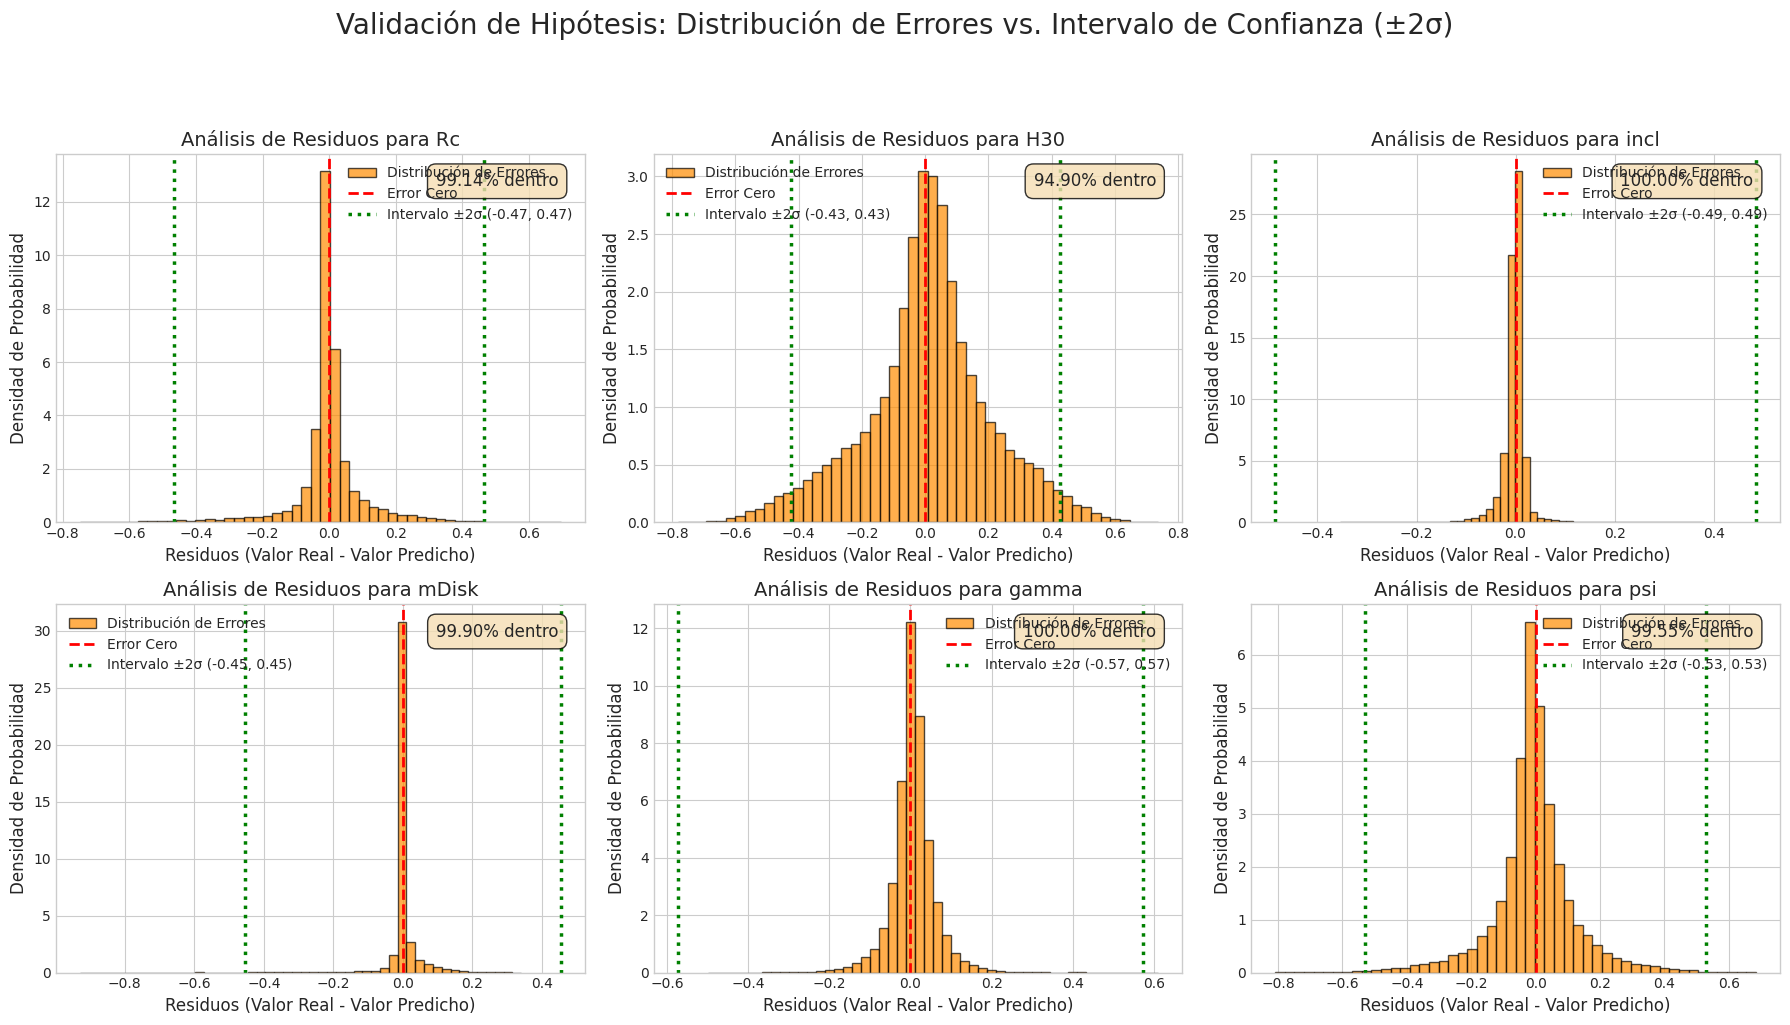

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_hypothesis_validation(targets_path, outputs_path, param_names):
    """
    Genera una figura con 6 histogramas de residuos, cada uno con los
    límites de +/- 2*sigma de los valores reales marcados.
    """
    try:
        targets = np.load(targets_path)
        outputs = np.load(outputs_path)
    except FileNotFoundError as e:
        print(f"Error: No se pudo encontrar el archivo de datos: {e}")
        return

    residuals = targets - outputs

    # Configuración del estilo y la figura (2 filas, 3 columnas)
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    fig.suptitle('Validación de Hipótesis: Distribución de Errores vs. Intervalo de Confianza (±2σ)', fontsize=20, y=1.02)
    
    # Aplanar el array de ejes para una fácil iteración
    axes = axes.flatten()

    for i, name in enumerate(param_names):
        ax = axes[i]
        
        param_targets = targets[:, i]
        param_residuals = residuals[:, i]

        # Calcular estadísticas clave
        sigma_real = np.std(param_targets)
        lower_bound = -2 * sigma_real
        upper_bound = 2 * sigma_real
        
        is_within_interval = (param_residuals >= lower_bound) & (param_residuals <= upper_bound)
        percentage_within = np.mean(is_within_interval) * 100

        # Graficar el histograma de los residuos
        ax.hist(param_residuals, bins=50, density=True, color='darkorange', alpha=0.7, edgecolor='black', label='Distribución de Errores')
        
        # Añadir la línea en cero (error ideal)
        ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Error Cero')
        
        # Añadir las líneas del intervalo de confianza
        ax.axvline(x=lower_bound, color='green', linestyle=':', linewidth=2.5, label=f'Intervalo ±2σ ({lower_bound:.2f}, {upper_bound:.2f})')
        ax.axvline(x=upper_bound, color='green', linestyle=':', linewidth=2.5)
        
        # Añadir texto con el resultado del porcentaje
        ax.text(0.95, 0.95, f'{percentage_within:.2f}% dentro',
                ha='right', va='top', transform=ax.transAxes,
                fontsize=12, bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.8))

        # Títulos y etiquetas
        ax.set_title(f'Análisis de Residuos para {name}', fontsize=14)
        ax.set_xlabel('Residuos (Valor Real - Valor Predicho)', fontsize=12)
        ax.set_ylabel('Densidad de Probabilidad', fontsize=12)
        ax.legend(fontsize=10)

    # Si hay menos de 6 gráficos, apagar los ejes sobrantes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig("hypothesis_validation_plot.png", dpi=300)
    print("Gráfico de validación de hipótesis guardado como 'hypothesis_validation_plot.png'")
    plt.show()


if __name__ == '__main__':
    TARGETS_FILE = '/home/aargomedo/TESIS/Modelos/Two-Six/ConOptunaAumentoDatos/swin_tiny/default/test_outputs.npy'
    OUTPUTS_FILE = '/home/aargomedo/TESIS/Modelos/Two-Six/ConOptunaAumentoDatos/swin_tiny/default/test_targets.npy'
    PARAMETER_NAMES = ['Rc', 'H30', 'incl', 'mDisk', 'gamma', 'psi']
    
    plot_hypothesis_validation(TARGETS_FILE, OUTPUTS_FILE, PARAMETER_NAMES)

Gráfico de validación de hipótesis guardado como 'hypothesis_validation_plot_final.png'


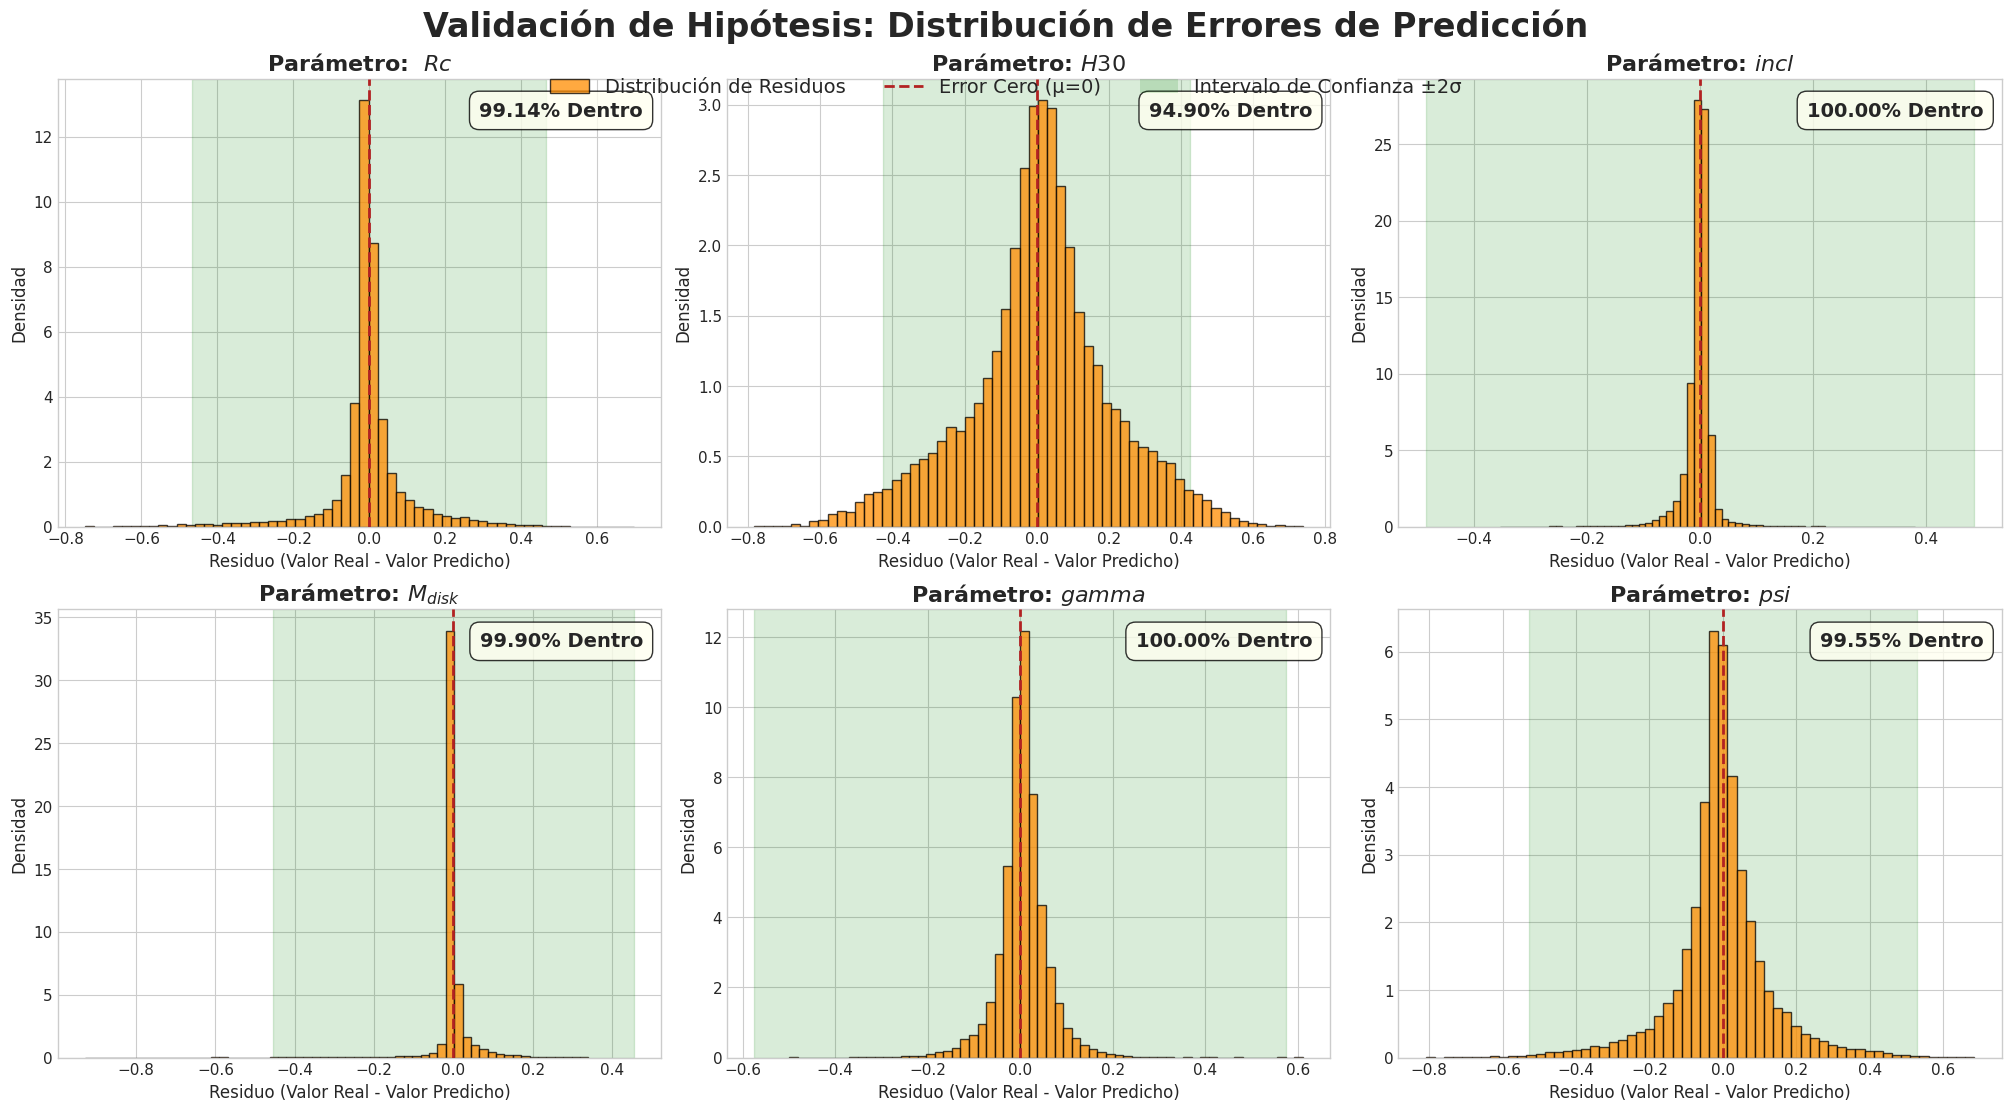

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_hypothesis_validation_final(targets_path, outputs_path, param_names):
    """
    Genera una figura de alta calidad con 6 histogramas de residuos,
    optimizada para evitar la superposición de etiquetas.
    """
    try:
        targets = np.load(targets_path)
        outputs = np.load(outputs_path)
    except FileNotFoundError as e:
        print(f"Error: No se pudo encontrar el archivo de datos: {e}")
        return

    residuals = targets - outputs

    # --- Configuración de Estilo y Figura ---
    plt.style.use('seaborn-v0_8-whitegrid')
    # constrained_layout=True es la clave para el espaciado automático
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 11), constrained_layout=True)
    fig.suptitle('Validación de Hipótesis: Distribución de Errores de Predicción', fontsize=24, fontweight='bold')
    
    axes = axes.flatten()

    for i, name in enumerate(param_names):
        ax = axes[i]
        
        param_targets = targets[:, i]
        param_residuals = residuals[:, i]

        # Calcular estadísticas clave
        sigma_real = np.std(param_targets)
        lower_bound = -2 * sigma_real
        upper_bound = 2 * sigma_real
        
        percentage_within = np.mean((param_residuals >= lower_bound) & (param_residuals <= upper_bound)) * 100

        # --- Graficar ---
        # Histograma de los residuos
        ax.hist(param_residuals, bins=60, density=True, color='darkorange', alpha=0.75, edgecolor='black', zorder=2)
        
        # Línea en cero (error ideal)
        ax.axvline(x=0, color='firebrick', linestyle='--', linewidth=2, zorder=3)
        
        # Rellenar el área del intervalo de confianza para mayor claridad visual
        ax.axvspan(lower_bound, upper_bound, color='green', alpha=0.15, zorder=1, label=f'Intervalo ±2σ ({lower_bound:.2f}, {upper_bound:.2f})')
        
        # Texto con el resultado del porcentaje
        ax.text(0.97, 0.95, f'{percentage_within:.2f}% Dentro',
                ha='right', va='top', transform=ax.transAxes,
                fontsize=14, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', fc='ivory', alpha=0.8))

        # --- Títulos y Etiquetas ---
        # Usamos LaTeX para los nombres de los parámetros para que se vean bien
        param_latex = f"${name.replace('mDisk', 'M_{disk}')}$" if len(name) > 2 else f"$\\ {name}$" # Ajuste para gamma y psi
        ax.set_title(f"Parámetro: {param_latex}", fontsize=16, fontweight='bold')
        ax.set_xlabel('Residuo (Valor Real - Valor Predicho)', fontsize=12)
        ax.set_ylabel('Densidad', fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=11)

    # --- Leyenda Global para toda la figura ---
    # Creamos manejadores de leyenda falsos para tener control total
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch

    legend_elements = [
        Patch(facecolor='darkorange', edgecolor='black', alpha=0.75, label='Distribución de Residuos'),
        Line2D([0], [0], color='firebrick', lw=2, linestyle='--', label='Error Cero (μ=0)'),
        Patch(facecolor='green', alpha=0.15, label='Intervalo de Confianza ±2σ')
    ]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3, fontsize=14)

    # Si hay menos de 6 gráficos, apagar los ejes sobrantes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
        
    # Guardar la figura
    output_filename = "hypothesis_validation_plot_final.png"
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"Gráfico de validación de hipótesis guardado como '{output_filename}'")
    plt.show()


if __name__ == '__main__':
    TARGETS_FILE = '/home/aargomedo/TESIS/Modelos/Two-Six/ConOptunaAumentoDatos/swin_tiny/default/test_outputs.npy'
    OUTPUTS_FILE = '/home/aargomedo/TESIS/Modelos/Two-Six/ConOptunaAumentoDatos/swin_tiny/default/test_targets.npy'
    PARAMETER_NAMES = ['Rc', 'H30', 'incl', 'mDisk', 'gamma', 'psi']
    
    plot_hypothesis_validation_final(TARGETS_FILE, OUTPUTS_FILE, PARAMETER_NAMES)